# Logistic Regression with a Neural Network mindset:

## 1. Numpy

We will build a logistic regression classifier to recognize cats. This notebook will step us through how to do this with a Neural Network mindset.

In computer science, an image is represented by a 3D array of shape $(length, height, depth = 3)$. However, when you read an image as the input of an algorithm you convert it to a vector of shape $(length*height*3, 1)$. In other words, you "unroll", or reshape, the 3D array into a 1D vector.

<img src="Images/image2vector_kiank.png" style="width:500px;height:300;">

#### General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

We will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4} = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$$

Here are the two formulas we will be using for backpropagation: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m} X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

**The main steps for building our Neural Network are:**
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current cost (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters minimizing the cost (gradient descent)
4. Use the learned parameters to make predictions (on the test set)
5. Analyse the results and conclude

First let's import all required packages:
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

Load Data.

In [2]:
# Loading the data (cat/non-cat)
x_train, y_train, x_test, y_test, classes = load_dataset()

In [3]:
print(x_train.shape)
print(x_test.shape)

(209, 64, 64, 3)
(50, 64, 64, 3)


Each x element is a picture, a (64,64,3) array.

In [4]:
print(x_train[0].shape)
x_train[0]

(64, 64, 3)


array([[[17, 31, 56],
        [22, 33, 59],
        [25, 35, 62],
        ..., 
        [ 1, 28, 57],
        [ 1, 26, 56],
        [ 1, 22, 51]],

       [[25, 36, 62],
        [28, 38, 64],
        [30, 40, 67],
        ..., 
        [ 1, 27, 56],
        [ 1, 25, 55],
        [ 2, 21, 51]],

       [[32, 40, 67],
        [34, 42, 69],
        [35, 42, 70],
        ..., 
        [ 1, 25, 55],
        [ 0, 24, 54],
        [ 1, 21, 51]],

       ..., 
       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

Each y[0,i] element is a binary that indicates cat or no cat.

In [5]:
print(y_train.shape)
y_train[0,25]

(1, 209)


1

cat


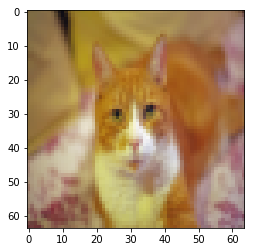

In [6]:
index = 24
plt.imshow(x_train[index])
print(classes[np.squeeze(y_train[0, index])].decode("utf-8"))

#### Reshape the training and test data sets so that images of size (64, 64, 3) are flattened into single vectors of shape (64 ∗ 64  ∗ 3, 1).

In [7]:
x_train_flattened = x_train.reshape(x_train.shape[0],-1).T
x_test_flattened = x_test.reshape(x_test.shape[0],-1).T

Now each column of x_train_flattened is a vectorized flattened image.

In [8]:
print(x_train_flattened.shape)
x_train_flattened

(12288, 209)


array([[ 17, 196,  82, ..., 143,  22,   8],
       [ 31, 192,  71, ..., 155,  24,  28],
       [ 56, 190,  68, ..., 165,  23,  53],
       ..., 
       [  0,  82, 138, ...,  85,   4,   0],
       [  0,  80, 141, ..., 107,   5,   0],
       [  0,  81, 142, ..., 149,   0,   0]], dtype=uint8)

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255. So to normalize our data we just devide by 255.

In [9]:
x_train_flattened = x_train_flattened/255
x_test_flattened = x_test_flattened/255

In [10]:
X = x_train_flattened
X_test = x_test_flattened
Y = y_train
Y_test = y_test

We define some functions that we will use for our model construction.

In [11]:
def initialize_parameters(dim):
    w = np.zeros((dim,1))
    b = 0
    return w, b

In [12]:
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

In [13]:
def forward(X, w, b):
    Y_hat = sigmoid(np.dot(w.T, X) + b)
    return Y_hat

In [14]:
def Y_prediction(X, w, b):
    Y_hat = forward(X, w, b)
    for j in range(X.shape[1]):
        if Y_hat[0,j] > 0.5:
            Y_hat[0,j] = 1
        else:
            Y_hat[0,j] = 0
    return Y_hat

**Define our main optimization function that calculates the parameters w, b minimizing the cost with gradient descent.**

In [15]:
def gradient_descent(X, Y, num_iterations, learning_rate, print_cost = True):
    m = X.shape[1]
    cost_list = []

    w, b = initialize_parameters(64*64*3)
    Y_hat = forward(X, w, b)
    cost = -(1/m)*np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1-Y_hat))
    cost_list.append(cost)
    
    for i in range(num_iterations):
        Y_hat = forward(X, w, b)
        dw = (1/m)*(np.dot(X,(Y_hat-Y).T))
        db = (1/m)*np.sum(Y_hat-Y)
        w = w - learning_rate*dw
        b = b - learning_rate*db
    
        if i % 100 == 0:
            cost = -(1/m)*np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1-Y_hat))
            cost_list.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i,cost))
        else: pass
        
    Y_hat_train = Y_prediction(X, w, b)
    Y_hat_test = Y_prediction(X_test, w, b)
    train_accuracy = 100 - np.mean(np.abs(Y_hat_train - Y))*100
    test_accuracy = 100 - np.mean(np.abs(Y_hat_test - Y_test))*100

    print("train accuracy: {}".format(train_accuracy))
    print("test accuracy: {}".format(test_accuracy))
    
    d = {"costs": cost_list,
         "Y_prediction_test": Y_hat_test, 
         "Y_prediction_train" : Y_hat_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Let's construct and evaluate our model:

In [16]:
d = gradient_descent(X, Y, num_iterations=2000, learning_rate=0.005, print_cost = True)

Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.5845083636993086
Cost after iteration 200: 0.4669490409465547
Cost after iteration 300: 0.37600686694802077
Cost after iteration 400: 0.3314632893282512
Cost after iteration 500: 0.30327306747438293
Cost after iteration 600: 0.2798795865826048
Cost after iteration 700: 0.2600421369258757
Cost after iteration 800: 0.2429406846779662
Cost after iteration 900: 0.22800422256726066
Cost after iteration 1000: 0.21481951378449635
Cost after iteration 1100: 0.20307819060644988
Cost after iteration 1200: 0.19254427716706862
Cost after iteration 1300: 0.18303333796883509
Cost after iteration 1400: 0.1743985943844888
Cost after iteration 1500: 0.16652139705400335
Cost after iteration 1600: 0.15930451829756614
Cost after iteration 1700: 0.15266732471296504
Cost after iteration 1800: 0.1465422350398234
Cost after iteration 1900: 0.14087207570310162
train accuracy: 99.04306220095694
test accuracy: 70.0


Changing Hyperparameters:

learning rate is: 0.01
train accuracy: 98.56459330143541
test accuracy: 70.0

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 96.65071770334929
test accuracy: 72.0

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 66.02870813397129
test accuracy: 36.0

-------------------------------------------------------



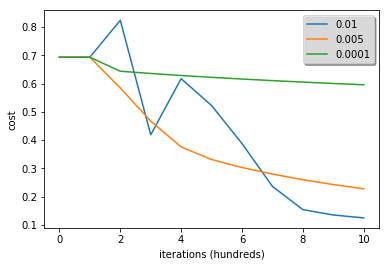

In [17]:
learning_rates = [0.01, 0.005, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = gradient_descent(X, Y, num_iterations=1000, learning_rate=i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**As we can see different hyperparamaters can lead to overvfit or underfit and also different accuracy scores.**

===========================================================================================================

## 2. PyTorch

Soon we will add a similar and very intriguing approach on this problem using the PyTorch deep learning library.